# 'Deploying' the models by feeding them collected real-world campus network traffic

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Collected network traffic has been processed by the LycoSTand program [1], to generate the unlabled dataset

In [2]:
path = os.getcwd()
extension = '.csv'

In [3]:
# Load the generated models
prep = joblib.load(f"{path}/Models/preprocessor.pkl")
models = ["dt", "knn", "rf"]
pipelines = []
for model_name in models:
    model = joblib.load(f"{path}/Models/{model_name}.pkl")
    pipelines.append((model_name, Pipeline([('Scaler', prep), (model_name, model)])))

In [4]:
# Concatenate all the datasets containing real network data into one dataframe
files = [file for file in os.listdir(f"{path}/realdata/") if file.endswith(extension)]
dfs = []
for file in files:
    df = pd.read_csv(os.path.join(f"{path}/realdata/", file))
    dfs.append(df)
fulldata = pd.concat(dfs, ignore_index=True)

In [5]:
fulldata.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,10.37.5.121-192.168.70.179-62634-7680-6,10.37.5.121,62634,192.168.70.179,7680,6,1708776002238646,302,0.500,0.0,0.0,0.000000,0.000000,0.000000,0.000000,9933.774834,6622.516556,3311.258278,2,0,0.0,0.0,0.00,0.000000,64,32,0,1,0,0.0,0.0,0.000000,0.000000,20,20,0,301.0,1.0,151.000000,212.132034,1,1.0,1.0,1.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,64240,0,NeedLabel
1,10.37.24.58-138.2.132.238-49696-10013-6,10.37.24.58,49696,138.2.132.238,10013,6,1708776002128867,191649,0.600,0.0,0.0,0.000000,0.000000,0.000000,0.000000,41.742978,26.089361,15.653617,5,0,0.0,0.0,0.00,0.000000,112,20,0,3,0,0.0,0.0,0.000000,0.000000,72,24,0,190371.0,0.0,27378.428571,71873.281452,191649,191105.0,1.0,47912.250000,95461.980730,579,579.0,0.0,289.500000,409.414826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0,5,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,2920,8192,NeedLabel
2,35.212.16.125-10.37.129.27-443-56942-6,35.212.16.125,443,10.37.129.27,56942,6,1708776002452018,207794,0.500,39.0,0.0,26.000000,507.000000,22.516660,375.371762,14.437375,9.624917,4.812458,2,78,39.0,39.0,39.00,0.000000,64,32,2,1,0,0.0,0.0,0.000000,0.000000,32,32,0,207793.0,1.0,103897.000000,146931.132276,1,1.0,1.0,1.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,3,2,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,2.0,0.0,1.0,501,97,NeedLabel
3,10.37.26.137-185.21.216.164-59559-54513-6,10.37.26.137,59559,185.21.216.164,54513,6,1708776002496236,558201,1.000,333.0,0.0,68.312500,11586.095833,107.638728,1958.076034,28.663510,14.331755,14.331755,8,624,244.0,0.0,78.00,106.669048,184,20,4,8,469,333.0,0.0,58.625000,115.041530,184,20,3,214567.0,0.0,37213.400000,76865.947007,343619,173190.0,0.0,49088.428571,83706.979810,388557,216572.0,0.0,55508.142857,95104.170826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,1,14,7,4,3,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,624.0,8.0,469.0,8.0,64240,65535,NeedLabel
4,10.37.8.150-10.37.19.12-59548-7680-6,10.37.8.150,59548,10.37.19.12,7680,6,1708776003020297,44923,0.875,75.0,0.0,23.733333,1059.638095,32.552083,7924.671104,333.904681,178.082497,155.822185,8,178,75.0,0.0,22.25,33.126381,184,20,4,7,178,75.0,0.0,25.428571,34.437659,164,20,4,40495.0,0.0,3208.785714,10744.572084,43521,40809.0,1.0,6217.285714,15279.033147,4427,2273.0,0.0,737.833333,1090.117134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0,13,8,4,4,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,178.0,8.0,178.0,7.0,64240,65535,NeedLabel


In [6]:
# Label the attack flows
fulldata.label[(fulldata['src_addr'] == '10.37.7.254') & (fulldata['dst_addr'] == '10.37.26.145')] = 1

In [7]:
fulldata.label[fulldata.label != 1] = 0 # Benign flows

In [8]:
data=fulldata[fulldata['ip_prot']==6] # consider only TCP protocol

In [9]:
# This will be used to track which flow has a different predicted label
data2=fulldata[fulldata['ip_prot']==6] # consider only TCP protocol

In [10]:
# Features to keep [1]
columns_var=['dst_port', 'ip_prot', 'flow_duration', 'down_up_ratio', 'pkt_len_max', 'bytes_per_s', 'pkt_per_s', 'fwd_pkt_cnt', 'fwd_pkt_len_tot', 'fwd_pkt_len_max', 'label']
data = data[columns_var]

In [11]:
data.label.value_counts()

label
1    589877
0    142708
Name: count, dtype: int64

In [12]:
# Seperate features and label data; this will be fed to the generated models
X_data = data.drop(columns = ["label"])
y_data = data.label
y_data = y_data.astype(int)
print(X_data.shape, y_data.shape)

(732585, 10) (732585,)


Model name:  DT
              precision    recall  f1-score   support

      benign     0.9261    0.8039    0.8607    142708
      attack     0.9540    0.9845    0.9690    589877

    accuracy                         0.9493    732585
   macro avg     0.9401    0.8942    0.9149    732585
weighted avg     0.9486    0.9493    0.9479    732585



Model name:  KNN
              precision    recall  f1-score   support

      benign     0.6358    0.5581    0.5944    142708
      attack     0.8962    0.9227    0.9092    589877

    accuracy                         0.8516    732585
   macro avg     0.7660    0.7404    0.7518    732585
weighted avg     0.8454    0.8516    0.8479    732585



Model name:  RF
              precision    recall  f1-score   support

      benign     0.9294    0.8422    0.8836    142708
      attack     0.9627    0.9845    0.9735    589877

    accuracy                         0.9568    732585
   macro avg     0.9460    0.9134    0.9286    732585
weighted avg     0.95

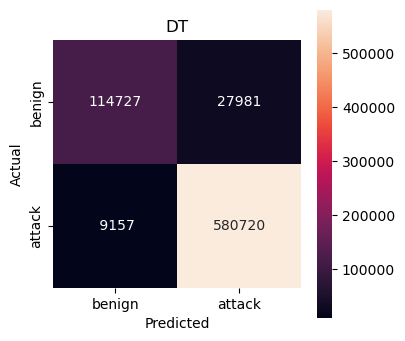

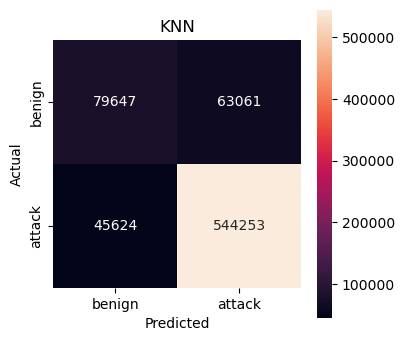

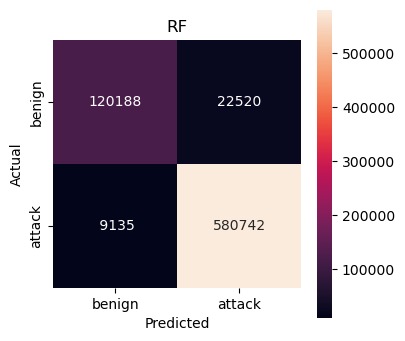

In [13]:
name = []
for name, clf in pipelines:
    model_test = clf.predict(X_data)
    print("Model name: ",name.upper())
    print(classification_report(y_data.values, model_test, digits=4, target_names=['benign','attack']))
    print("\n")
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    cm = confusion_matrix(y_data.values, model_test)
    ax = sns.heatmap(cm, annot=True, fmt='5g', square=True, xticklabels=['benign','attack'], yticklabels=['benign','attack'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(name.upper())
    data2[name.upper()] = model_test # add the column with predicted labels

## Which attack flows have been mispredicted by the RF model

In [14]:
fn = data2[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & ((data2['label'] == 1) & (data2['RF'] == 0))].drop(columns = ['DT', 'KNN'])
fn["Time (UTC)"] = pd.to_datetime(fn["timestamp"], unit='us') # add a Time column

In [15]:
# A peek into the mispredicted attack flows
fn.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label,RF,Time (UTC)
1277755,10.37.7.254-10.37.26.145-38077-5900-6,10.37.7.254,38077,10.37.26.145,5900,6,1708774202455142,451,0.5,8.0,0.0,2.666667,21.333333,4.618802,17738.359202,6651.884701,4434.589800,2217.294900,2,8,8.0,0.0,4.0,5.656854,20,0,1,1,0,0.0,0.0,0.0,0.0,24,24,0,344.0,107.0,225.5,167.584307,451,451.0,451.0,451.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0,64240,1,0,2024-02-24 11:30:02.455142
1278004,10.37.7.254-10.37.26.145-38114-21-6,10.37.7.254,38114,10.37.26.145,21,6,1708774236559214,313,0.5,8.0,0.0,2.666667,21.333333,4.618802,25559.105431,9584.664537,6389.776358,3194.888179,2,8,8.0,0.0,4.0,5.656854,20,0,1,1,0,0.0,0.0,0.0,0.0,24,24,0,208.0,105.0,156.5,72.831998,313,313.0,313.0,313.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0,64240,1,0,2024-02-24 11:30:36.559214
1278045,10.37.7.254-10.37.26.145-38121-21-6,10.37.7.254,38121,10.37.26.145,21,6,1708774245328005,290,0.5,8.0,0.0,2.666667,21.333333,4.618802,27586.206897,10344.827586,6896.551724,3448.275862,2,8,8.0,0.0,4.0,5.656854,20,0,1,1,0,0.0,0.0,0.0,0.0,24,24,0,195.0,95.0,145.0,70.710678,290,290.0,290.0,290.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0,64240,1,0,2024-02-24 11:30:45.328005
1278124,10.37.7.254-10.37.26.145-38131-21-6,10.37.7.254,38131,10.37.26.145,21,6,1708774257843705,334,0.5,8.0,0.0,2.666667,21.333333,4.618802,23952.095808,8982.035928,5988.023952,2994.011976,2,8,8.0,0.0,4.0,5.656854,20,0,1,1,0,0.0,0.0,0.0,0.0,24,24,0,288.0,46.0,167.0,171.119841,334,334.0,334.0,334.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0,64240,1,0,2024-02-24 11:30:57.843705
1278138,10.37.7.254-10.37.26.145-38077-1433-6,10.37.7.254,38077,10.37.26.145,1433,6,1708774259548859,485,0.5,8.0,0.0,2.666667,21.333333,4.618802,16494.845361,6185.567010,4123.711340,2061.855670,2,8,8.0,0.0,4.0,5.656854,20,0,1,1,0,0.0,0.0,0.0,0.0,24,24,0,458.0,27.0,242.5,304.763023,485,485.0,485.0,485.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0,64240,1,0,2024-02-24 11:30:59.548859


In [16]:
# Uncomment following line to save a copy of the mispredicted attacks
#fn.to_csv("misPredictedOfRF.csv", index=False)

# References
>[1] A. Rosay, F. Carlier, E. Cheval, and P. Leroux, “From CIC-IDS2017 to LYCOS-IDS2017: A corrected dataset for better performance,” in IEEE/WIC/ACM International Conference on Web Intelligence, ESSENDON VIC Australia: ACM, Dec. 2021, pp. 570–575. doi: 10.1145/3486622.3493973.\